# Pool of water

In [ ]:
using OrdinaryDiffEq, Plots, Plots.Measures

prob = ODEProblem((u,p,t) -> [u[1] - 2], [100.0], (0.0, 4*pi))

sol = solve(prob, Tsit5())
plot(sol, lw=2, bottom_margin=10mm, left_margin=10mm, title = "A pool of water", label=["water in pool" "season"])
xlabel!("Time")


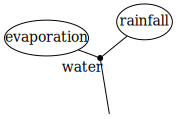

In [10]:
# pool pattern
using Catlab, Catlab.WiringDiagrams, Catlab.Programs, Catlab.Graphics

pool_pattern = @relation (water,) begin
    evaporation(water)
    rainfall(water)
end
gv = to_graphviz(pool_pattern, box_labels = :name, junction_labels = :variable, edge_attrs=Dict(:len => ".75")) #hide


In [2]:
# pool primitives
using AlgebraicDynamics, AlgebraicDynamics.UWDDynam
using LabelledArrays
p = LVector(α = 0.3, β = 0.5 )

dotw (u,p,t) = -p.α*u[1]
dotwr(u,p,t) = [p.β * sin(t)]

evaporation = ContinuousResourceSharer{Float64}(1, 1, dotwe, [1])
rainfall = ContinuousResourceSharer{Float64}(1, 2, dotwr, [1])

┌ Info: Precompiling AlgebraicDynamics [5fd6ff03-a254-427e-8840-ba658f502e32]
└ @ Base loading.jl:1278
ERROR: LoadError: ArgumentError: Package ChainRulesCore does not have Compat in its dependencies:
- If you have ChainRulesCore checked out for development and have
  added Compat as a dependency but haven't updated your primary
  environment's manifest file, try `Pkg.resolve()`.
- Otherwise you may need to report an issue with ChainRulesCore
Stacktrace:
 [1] require(::Module, ::Symbol) at ./loading.jl:906
 [2] include(::Function, ::Module, ::String) at ./Base.jl:380
 [3] include(::Module, ::String) at ./Base.jl:368
 [4] top-level scope at none:2
 [5] eval at ./boot.jl:331 [inlined]
 [6] eval(::Expr) at ./client.jl:467
 [7] top-level scope at ./none:3
in expression starting at /Users/slibkind/.julia/packages/ChainRulesCore/qeIhO/src/ChainRulesCore.jl:5
ERROR: LoadError: Failed to precompile ChainRulesCore [d360d2e6-b24c-11e9-a2a3-2a2ae2dbcce4] to /Users/slibkind/.julia/compiled/v1.5/Ch

LoadError: Failed to precompile AlgebraicDynamics [5fd6ff03-a254-427e-8840-ba658f502e32] to /Users/slibkind/.julia/compiled/v1.5/AlgebraicDynamics/h1DsC_TAN37.ji.

In [ ]:
using OrdinaryDiffEq, Plots, Plots.Measures

# pool compose
pool_system = oapply(pool_pattern, [evaporation, rainfall])

u0 = [0.0, 0.0] # initial condition - water = 0, season = 0
years = 5
tspan = (0.0, years*2*pi)
prob = ODEProblem(pool_system, u0, tspan)
sol = solve(prob, Tsit5())

plot(sol, lw=2, bottom_margin=10mm, left_margin=10mm, title = "A pool of water", label=["water in pool" "season"])
xlabel!("Time")

# Ecosystem

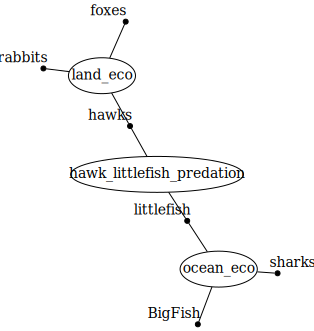

In [39]:
# eco pattern
eco_pattern = @relation () where (rabbits, foxes, hawks, littlefish, BigFish, sharks)  begin
    land_eco(rabbits,foxes,hawks)
    hawk_littlefish_predation(hawks, littlefish)
    ocean_eco(littlefish, BigFish, sharks)
end
gv = to_graphviz(eco_pattern, box_labels = :name, junction_labels = :variable, edge_attrs=Dict(:len => ".75"))#hide

In [ ]:
# rabbit fox pattern

rabbitfox_pattern = @relation (rabbits, foxes)  begin
    rabbit_growth(rabbits)
    rabbit_fox_predation(rabbits,foxes)
    fox_decline(foxes)
end

gv = to_graphviz(rabbitfox_pattern, box_labels = :name, junction_labels = :variable, edge_attrs=Dict(:len => ".75")) #hide

In [ ]:
# rabbit hawk pattern
rabbithawk_pattern = @relation (rabbits, hawks)  begin
    rabbit_growth(rabbits)
    rabbit_hawk_predation(rabbits,hawks)
    hawk_decline(hawks)
end

gv = to_graphviz(rabbithawk_pattern, box_labels = :name, junction_labels = :variable, edge_attrs=Dict(:len => ".75")) #hide

In [ ]:
# pushout
using Catlab.CategoricalAlgebra
# Define the composition pattern for rabbit growth
rabbit_pattern = @relation (rabbits,) -> rabbit_growth(rabbits)

# Define transformations between the composition patterns
rabbitfox_transform  = ACSetTransformation((Box=[1], Junction=[1], Port=[1], OuterPort=[1]), rabbit_pattern, rabbitfox_pattern)
rabbithawk_transform = ACSetTransformation((Box=[1], Junction=[1], Port=[1], OuterPort=[1]), rabbit_pattern, rabbithawk_pattern)

# Take the pushout
land_pattern = ob(pushout(rabbitfox_transform, rabbithawk_transform))

gv = to_graphviz(land_pattern, box_labels = :name, junction_labels = :variable, edge_attrs=Dict(:len => ".9")) #hide

In [23]:
# land compose
α, β, γ, δ, β′, γ′, δ′ = 0.3, 0.015, 0.015, 0.7, .01, .01, .5

dotr(u,p,t)  = α*u
dotrf(u,p,t) = [-β*u[1]*u[2], γ*u[1]*u[2]]
dotf(u,p,t)  = -δ*u
dotrh(u, p, t) = [-β′*u[1]*u[2], γ′*u[1]*u[2]]
doth(u, p, t)  = -δ′*u

# Define the primitive systems
rabbit_growth       = ContinuousResourceSharer{Float64}(1, 1, dotr,  [1])
rabbitfox_predation = ContinuousResourceSharer{Float64}(2, 2, dotrf, [1,2])
fox_decline         = ContinuousResourceSharer{Float64}(1, 1, dotf,  [1])
rabbithawk_predation= ContinuousResourceSharer{Float64}(2, 2, dotrh, [1,2])
hawk_decline        = ContinuousResourceSharer{Float64}(1, 1, doth,  [1])

# Compose
land_sys= oapply(land_pattern, [rabbit_growth, rabbitfox_predation, fox_decline, rabbithawk_predation, hawk_decline])

ContinuousResourceSharer(ℝ^3 → ℝ^3) with 3 exposed ports

In [24]:
# air
γ′′, β′′ = 0.001, 0.003
dothf(u,p,t) = [γ′′*u[1]*u[2], -β′′*u[1]*u[2]]
air_sys = ContinuousResourceSharer{Float64}(2, 2, dothf, [1,2])

ContinuousResourceSharer(ℝ^2 → ℝ^2) with 2 exposed ports

In [25]:
# water dwd
using AlgebraicDynamics.DWDDynam
dotfish(f, x, p, t) = [0.35*f[1] - 0.015*x[1]*f[1]]
dotFISH(F, x, p, t) = [.015*x[1]*F[1] - 0.7*F[1] - 0.017*x[2]*F[1]]    # p[1] - prey, p[2] - predator
dotsharks(s, x, p, t) = [0.017*s[1]*x[1]-0.35*s[1]]

# Define the primitive systems
fish   = ContinuousMachine{Float64}(1,1,1, dotfish,   f->f)
FISH   = ContinuousMachine{Float64}(2,1,1, dotFISH,   F->F)
sharks = ContinuousMachine{Float64}(1,1,1, dotsharks, s->s)

# define the composition pattern
ocean_pattern = WiringDiagram([], [])
fish_box = add_box!(ocean_pattern, Box("little fish", [:pop], [:pop]))
Fish_box = add_box!(ocean_pattern, Box("Big Fish", [:pop, :pop], [:pop]))
shark_box = add_box!(ocean_pattern, Box("sharks", [:pop], [:pop]))

add_wires!(ocean_pattern, Pair[
    (fish_box, 1)  => (Fish_box, 1),
    (shark_box, 1) => (Fish_box, 2),
    (Fish_box, 1)  => (fish_box, 1),
    (Fish_box, 1)  => (shark_box, 1)
])

# compose
ocean_sys = oapply(ocean_pattern, [fish, FISH, sharks])

ContinuousMachine(ℝ^3 × ℝ^0 → ℝ^3)

In [26]:
# water
ocean_sys_rs = ContinuousResourceSharer{Float64}(3, (u,p,t)->eval_dynamics(ocean_sys, u, [], p, t))

ContinuousResourceSharer(ℝ^3 → ℝ^3) with 3 exposed ports

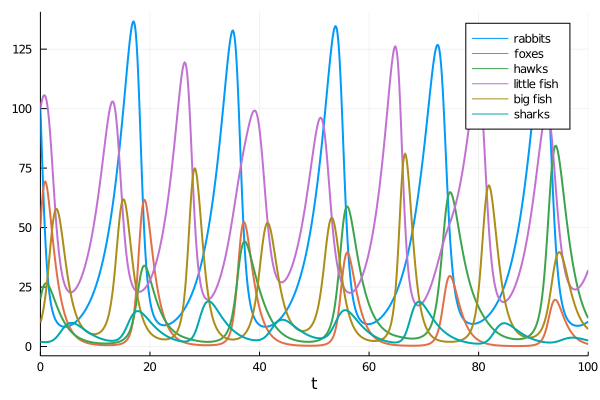

In [33]:
# total eco

# Compose
eco_system = oapply(eco_pattern, [land_sys, air_sys, ocean_sys_rs])

# Plot and sovle
u0 = [100.0, 50.0, 20.0, 100, 10, 2.0]
tspan = (0.0, 100.0)
prob = ODEProblem(eco_system, u0, tspan)
sol = solve(prob, Tsit5())
plot(sol, lw=2, label = ["rabbits" "foxes" "hawks" "little fish" "big fish" "sharks"])

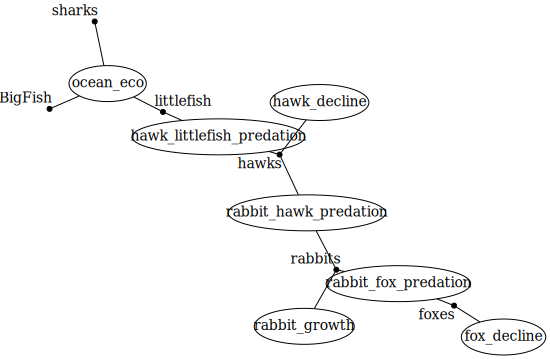

In [29]:
# flattened system

# Define the (flattened) composition pattern
flattened_pattern = ocompose(eco_pattern, 1, land_pattern)

#Compose
eco_sys2 = oapply(flattened_pattern, [rabbit_growth, rabbitfox_predation, fox_decline, rabbithawk_predation, hawk_decline, air_sys, ocean_sys_rs])
gv = to_graphviz(flattened_pattern, box_labels = :name, junction_labels = :variable, edge_attrs=Dict(:len => ".8"))


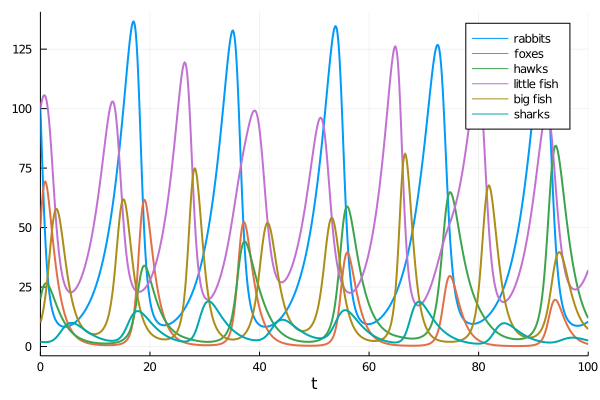

In [30]:
prob = ODEProblem(eco_sys2, u0, tspan)
sol = solve(prob, Tsit5())
plot(sol, lw=2, label = ["rabbits" "foxes" "hawks" "little fish" "big fish" "sharks"])

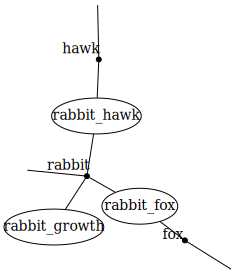

In [11]:
pat = @relation (rabbit, fox, hawk) begin
    rabbit_growth(rabbit)
    rabbit_fox(rabbit, fox)
    rabbit_hawk(rabbit, hawk)
end
gv = to_graphviz(pat, box_labels = :name, junction_labels = :variable, edge_attrs=Dict(:len => ".75"))